# EasyVisa Project

## Context:

Business communities in the United States are facing high demand for human resources, but one of the constant challenges is identifying and attracting the right talent, which is perhaps the most important element in remaining competitive. Companies in the United States look for hard-working, talented, and qualified individuals both locally as well as abroad.

The Immigration and Nationality Act (INA) of the US permits foreign workers to come to the United States to work on either a temporary or permanent basis. The act also protects US workers against adverse impacts on their wages or working conditions by ensuring US employers' compliance with statutory requirements when they hire foreign workers to fill workforce shortages. The immigration programs are administered by the Office of Foreign Labor Certification (OFLC).

OFLC processes job certification applications for employers seeking to bring foreign workers into the United States and grants certifications in those cases where employers can demonstrate that there are not sufficient US workers available to perform the work at wages that meet or exceed the wage paid for the occupation in the area of intended employment.

## Objective:

In FY 2016, the OFLC processed 775,979 employer applications for 1,699,957 positions for temporary and permanent labor certifications. This was a nine percent increase in the overall number of processed applications from the previous year. The process of reviewing every case is becoming a tedious task as the number of applicants is increasing every year.

The increasing number of applicants every year calls for a Machine Learning based solution that can help in shortlisting the candidates having higher chances of VISA approval. OFLC has hired your firm EasyVisa for data-driven solutions. You as a data scientist have to analyze the data provided and, with the help of a classification model:

* Facilitate the process of visa approvals.
* Recommend a suitable profile for the applicants for whom the visa should be certified or denied based on the drivers that significantly influence the case status.


## Data Description

The data contains the different attributes of the employee and the employer. The detailed data dictionary is given below.

* case_id: ID of each visa application
* continent: Information of continent the employee
* education_of_employee: Information of education of the employee
* has_job_experience: Does the employee has any job experience? Y= Yes; N = No
* requires_job_training: Does the employee require any job training? Y = Yes; N = No
* no_of_employees: Number of employees in the employer's company
* yr_of_estab: Year in which the employer's company was established
* region_of_employment: Information of foreign worker's intended region of employment in the US.
* prevailing_wage:  Average wage paid to similarly employed workers in a specific occupation in the area of intended employment. The purpose of the prevailing wage is to ensure that the foreign worker is not underpaid compared to other workers offering the same or similar service in the same area of employment.
* unit_of_wage: Unit of prevailing wage. Values include Hourly, Weekly, Monthly, and Yearly.
* full_time_position: Is the position of work full-time? Y = Full Time Position; N = Part Time Position
* case_status:  Flag indicating if the Visa was certified or denied

## Importing necessary libraries and data

In [1]:
# Installing the libraries with the specified version.
!pip install numpy==1.25.2 pandas==1.5.3 scikit-learn==1.2.2 matplotlib==3.7.1 seaborn==0.13.1 xgboost==2.0.3

**Note**: *After running the above cell, kindly restart the notebook kernel and run all cells sequentially from the start again.*

In [2]:
# libraries to read and manipulate data
import numpy as np
import pandas as pd

# libraries to visualize data
import matplotlib.pyplot as plt
import seaborn as sns

# libraries for model building and tuning
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (BaggingClassifier,RandomForestClassifier, 
                              GradientBoostingClassifier, AdaBoostClassifier, StackingClassifier)
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

# libraries for metrics and statistics
from sklearn import metrics
import scipy.stats as stats
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score, roc_auc_score

import warnings
warnings.filterwarnings('ignore')

In [3]:
# reading csv file into a pandas Dataframe
visa = '/Users/daniabankesly/Downloads/EasyVisa.csv'
df = pd.read_csv(visa)

In [4]:
# format numeric data for easier readability
pd.set_option(
    "display.float_format", lambda x: "%.2f" % x
)  # to display numbers rounded off to 2 decimal places

In [5]:
# function to create labeled barplots

def labeled_barplot(data, feature, feature_2, order, perc=False, n=None):
    """
    Barplot with percentage at the top

    data: dataframe
    feature: dataframe column
    feature_2: dataframe column
    perc: whether to display percentages instead of count (default is False)
    n: displays the top n category levels (default is None, i.e., display all levels)
    """

    total = len(data[feature])  # length of the column
    count = data[feature].nunique()
    if n is None:
        plt.figure(figsize=(count + 1, 5))
    else:
        plt.figure(figsize=(n + 1, 5))
        
    ax = sns.countplot(
        data=data,
        x=feature,
        palette='magma',
        order=order,
        hue=feature_2,
    )

    for p in ax.patches:
        if perc == True:
            label = "{:.1f}%".format(
                100 * p.get_height() / total
            )  # percentage of each class of the category
        else:
            label = p.get_height()  # count of each level of the category

        x = p.get_x() + p.get_width() / 2  # width of the plot
        y = p.get_height()  # height of the plot

        ax.annotate(
            label,
            (x, y),
            ha="center",
            va="center",
            size=9,
            xytext=(0, 5),
            textcoords="offset points"
        )  # annotate the percentages

    plt.show()  # to show the plot

In [6]:
# function to plot a boxplot and a histogram along the same scale

def histogram_boxplot(data, feature, figsize=(16, 6), kde=False, bins=None, hue=None):
    """
    Combines boxplot and histogram

    data: dataframe
    feature: dataframe column
    figsize: size of figure (default (16,6))
    kde: whether to show the density curve (default False)
    bins: number of bins for histogram (default None)
    """
    f2, (ax_box2, ax_hist2) = plt.subplots(
        nrows=2,  # number of rows of the subplot grid= 2
        sharex=True,  # x-axis will be shared among all subplots
        gridspec_kw={"height_ratios": (0.25, 0.75)},
        figsize=figsize,
    )  # creating the 2 subplots
    sns.boxplot(
        data=data, x=feature, ax=ax_box2, showmeans=True, palette="magma"
    )  # boxplot will be created and a star will indicate the mean value of the column
    sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2, bins=bins, palette="magma",
    ) if bins else sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2, palette="magma"
    )  # for histogram
    ax_hist2.axvline(
        data[feature].mean(), color="red", linestyle="--"
    )  # add mean to the histogram
    ax_hist2.axvline(
        data[feature].median(), color="black", linestyle="-"
    )  # add median to the histogram

In [7]:
# function to plot stacked bar chart

def stacked_barplot(data, predictor, target):
    """
    Print the category counts and plot a stacked bar chart

    data: dataframe
    predictor: independent variable
    target: target variable
    """
    count = data[predictor].nunique()
    sorter = data[target].value_counts().index[-1]
    tab1 = pd.crosstab(data[predictor], data[target], margins=True).sort_values(
        by=sorter, ascending=False
    )
    print(tab1)
    print("-" * 120)
    tab = pd.crosstab(data[predictor], data[target], normalize="index").sort_values(
        by=sorter, ascending=False
    )
    tab.plot(kind="bar", stacked=True, figsize=(count + 1, 5), cmap='magma')
    plt.legend(
        loc="lower left",
        frameon=False,
    )
    plt.legend(loc="upper left", bbox_to_anchor=(1, 1))
    plt.show()

## Data Overview

- Observations
- Sanity checks

In [8]:
# print first five rows
df.head()

,case_id,continent,education_of_employee,has_job_experience,requires_job_training,no_of_employees,yr_of_estab,region_of_employment,prevailing_wage,unit_of_wage,full_time_position,case_status
0,EZYV01,Asia,High School,N,N,14513,2007,West,592.20,Hour,Y,Denied
1,EZYV02,Asia,Master's,Y,N,2412,2002,Northeast,83425.65,Year,Y,Certified
2,EZYV03,Asia,Bachelor's,N,Y,44444,2008,West,122996.86,Year,Y,Denied
3,EZYV04,Asia,Bachelor's,N,N,98,1897,West,83434.03,Year,Y,Denied
4,EZYV05,Africa,Master's,Y,N,1082,2005,South,149907.39,Year,Y,Certified


In [9]:
# print last five rows
df.tail()

,case_id,continent,education_of_employee,has_job_experience,requires_job_training,no_of_employees,yr_of_estab,region_of_employment,prevailing_wage,unit_of_wage,full_time_position,case_status
25475,EZYV25476,Asia,Bachelor's,Y,Y,2601,2008,South,77092.57,Year,Y,Certified
25476,EZYV25477,Asia,High School,Y,N,3274,2006,Northeast,279174.79,Year,Y,Certified
25477,EZYV25478,Asia,Master's,Y,N,1121,1910,South,146298.85,Year,N,Certified
25478,EZYV25479,Asia,Master's,Y,Y,1918,1887,West,86154.77,Year,Y,Certified
25479,EZYV25480,Asia,Bachelor's,Y,N,3195,1960,Midwest,70876.91,Year,Y,Certified


In [10]:
# print shape of dataset
df.shape

(25480, 12)

### Observations
* EasyVisa dataset has 25,480 rows and 12 columns

In [11]:
df.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
case_id,25480,25480,EZYV01,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
continent,25480,6,Asia,16861,NaN,NaN,NaN,NaN,NaN,NaN,NaN
education_of_employee,25480,4,Bachelor's,10234,NaN,NaN,NaN,NaN,NaN,NaN,NaN
has_job_experience,25480,2,Y,14802,NaN,NaN,NaN,NaN,NaN,NaN,NaN
requires_job_training,25480,2,N,22525,NaN,NaN,NaN,NaN,NaN,NaN,NaN
no_of_employees,25480.00,NaN,NaN,NaN,5667.04,22877.93,-26.00,1022.00,2109.00,3504.00,602069.00
yr_of_estab,25480.00,NaN,NaN,NaN,1979.41,42.37,1800.00,1976.00,1997.00,2005.00,2016.00
region_of_employment,25480,5,Northeast,7195,NaN,NaN,NaN,NaN,NaN,NaN,NaN
prevailing_wage,25480.00,NaN,NaN,NaN,74455.81,52815.94,2.14,34015.48,70308.21,107735.51,319210.27
unit_of_wage,25480,4,Year,22962,NaN,NaN,NaN,NaN,NaN,NaN,NaN


* The average wage is around $74,455
* The largest company has over 600k employees
* The oldest company was established in 1800 and the newest was established in 2016, which is a wide range
* The most popular continent from where job applicants are immigrating from is Asia
* Majority of immigrants have a Bachelor's degree
* The top region of employment is the Northeast

In [12]:
# print the column data types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25480 entries, 0 to 25479
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   case_id                25480 non-null  object 
 1   continent              25480 non-null  object 
 2   education_of_employee  25480 non-null  object 
 3   has_job_experience     25480 non-null  object 
 4   requires_job_training  25480 non-null  object 
 5   no_of_employees        25480 non-null  int64  
 6   yr_of_estab            25480 non-null  int64  
 7   region_of_employment   25480 non-null  object 
 8   prevailing_wage        25480 non-null  float64
 9   unit_of_wage           25480 non-null  object 
 10  full_time_position     25480 non-null  object 
 11  case_status            25480 non-null  object 
dtypes: float64(1), int64(2), object(9)
memory usage: 2.3+ MB


* The majority, specifically 9, of the twelve columns are Dtype object, and there are only 2 int64 and one float64
* It may be helpful to convert the Dtype object columns to categories, as to reduce the memory required to store the dataframe

In [13]:
# checking for duplicate values
df[df.duplicated()]

,case_id,continent,education_of_employee,has_job_experience,requires_job_training,no_of_employees,yr_of_estab,region_of_employment,prevailing_wage,unit_of_wage,full_time_position,case_status


* There are niether duplicate nor missing values in the dataset

In [14]:
# convert all columns of dtype object to category
for col in df.columns[df.dtypes=='object']:
    df[col] = df[col].astype('category')

* Our target variable of interest for the models is `case_status`
* `case_id` is randomly assigned by Immigration and Nationality Act (INA) to each case, which is not helpful in providing any material information for model building. Let's drop it

In [15]:
# drop the column *case_id* from the dataframe
df.drop(labels='case_id', axis=1, inplace=True)

In [16]:
# confirm Dtype conversions and variable dropped
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25480 entries, 0 to 25479
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   continent              25480 non-null  category
 1   education_of_employee  25480 non-null  category
 2   has_job_experience     25480 non-null  category
 3   requires_job_training  25480 non-null  category
 4   no_of_employees        25480 non-null  int64   
 5   yr_of_estab            25480 non-null  int64   
 6   region_of_employment   25480 non-null  category
 7   prevailing_wage        25480 non-null  float64 
 8   unit_of_wage           25480 non-null  category
 9   full_time_position     25480 non-null  category
 10  case_status            25480 non-null  category
dtypes: category(8), float64(1), int64(2)
memory usage: 797.7 KB


* Now, the memory required to store the dataframe is ~ 800kB, a third the size of the original dataframe. 
* Additionally, `object` Dtypes have successfully been converted to `category` Dtypes

## Exploratory Data Analysis (EDA)

- EDA is an important part of any project involving data.
- It is important to investigate and understand the data better before building a model with it.
- A few questions have been mentioned below which will help you approach the analysis in the right manner and generate insights from the data.
- A thorough analysis of the data, in addition to the questions mentioned below, should be done.

**Leading Questions**:
1. Those with higher education may want to travel abroad for a well-paid job. Does education play a role in Visa certification?

2. How does the visa status vary across different continents?

3. Experienced professionals might look abroad for opportunities to improve their lifestyles and career development. Does work experience influence visa status?

4. In the United States, employees are paid at different intervals. Which pay unit is most likely to be certified for a visa?

5. The US government has established a prevailing wage to protect local talent and foreign workers. How does the visa status change with the prevailing wage?

### 1. Those with higher education may want to travel abroad for a well-paid job. Does education play a role in Visa certification?

In [17]:
# group data by education_of_employee and show values for each category
df.groupby('education_of_employee')['case_status'].value_counts()

education_of_employee  case_status
Bachelor's             Certified      6367
                       Denied         3867
Doctorate              Certified      1912
                       Denied          280
High School            Denied         2256
                       Certified      1164
Master's               Certified      7575
                       Denied         2059
Name: case_status, dtype: int64

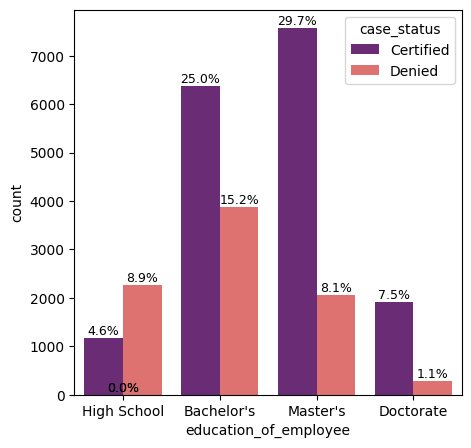

In [18]:
# create plot of above data, include percent of each group within the total number of cases
labeled_barplot(df,'education_of_employee','case_status', order=["High School","Bachelor's","Master's","Doctorate"], perc=True)

* The graph depicted above indicates a notable increase in the ratio of approved to denied applications as the highest level of education attained by an applicant rises. 
* For instance, the ratio for approval to denial is approximately 1:2 for applicants with a high school diploma, whereas it is approximately 7:1 for those with a doctorate.

### 2. How does the visa status vary across different continents?

In [19]:
# group data by continent and show values for each category
df.groupby('continent')['case_status'].value_counts()

continent      case_status
Africa         Certified        397
               Denied           154
Asia           Certified      11012
               Denied          5849
Europe         Certified       2957
               Denied           775
North America  Certified       2037
               Denied          1255
Oceania        Certified        122
               Denied            70
South America  Certified        493
               Denied           359
Name: case_status, dtype: int64

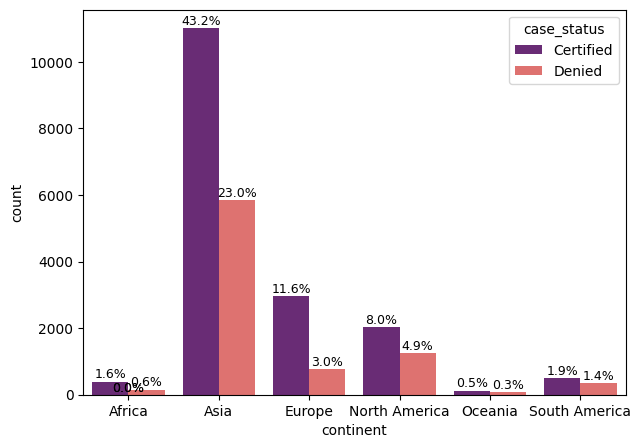

In [20]:
# create plot of the above data, include percent of each group within the total number of cases
labeled_barplot(df,'continent','case_status', order=None, perc=True)

* Around two-thirds of all applications originate from Asia, with these applicants enjoying nearly double the ratio of approvals to denials. 
* Conversely, European applicants boast the most favorable ratio of approvals to denials, standing at approximately 4:1.

### 3. Experienced professionals might look abroad for opportunities to improve their lifestyles and career development. Does work experience influence visa status?

In [21]:
# group data by has_job_experience and show values for each category
df.groupby('has_job_experience')['case_status'].value_counts()

has_job_experience  case_status
N                   Certified       5994
                    Denied          4684
Y                   Certified      11024
                    Denied          3778
Name: case_status, dtype: int64

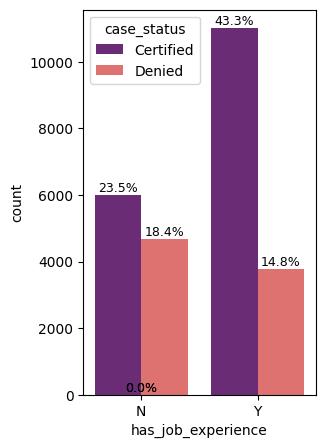

In [22]:
# create a plot of the above data, include percent of each group within the total number of cases
labeled_barplot(df,'has_job_experience','case_status', order=None, perc=True)

* Applicants with job experience enjoy a ratio of approximately 3:1 of approved to denied applications, whereas those without job experience have a nearly equivalent ratio of around 5:4.

### 4. In the United States, employees are paid at different intervals. Which pay unit is most likely to be certified for a visa?

In [23]:
# group data by unit_of_wage and show values for each category
df.groupby('unit_of_wage')['case_status'].value_counts()

unit_of_wage  case_status
Hour          Denied          1410
              Certified        747
Month         Certified         55
              Denied            34
Week          Certified        169
              Denied           103
Year          Certified      16047
              Denied          6915
Name: case_status, dtype: int64

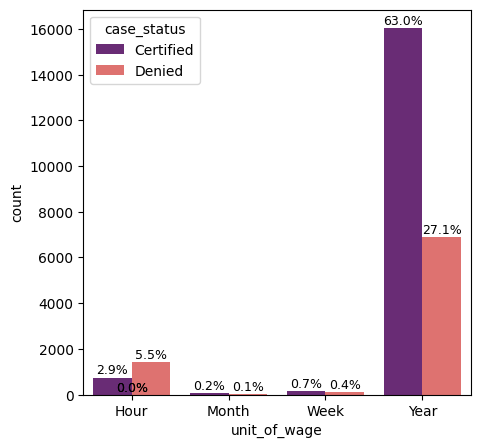

In [24]:
# create a plot of the above data, include percent of each group within the total number of cases
labeled_barplot(df,'unit_of_wage','case_status', order=None, perc=True)

* Candidates seeking positions with an hourly wage face a ratio of approved to denied applications approximately 1:2. Although only about 8% of all applications, they represent around 17% of all denials. 
* Applicants categorized under any other `unit_of_wage` exhibit a ratio of approximately 2:1, with applications for roles offering annual salaries showcasing nearly a 2.5:1 ratio of approvals to denials.

## Data Preprocessing

- Missing value treatment (if needed)
- Feature engineering
- Outlier detection and treatment (if needed)
- Preparing data for modeling
- Any other preprocessing steps (if needed)

In [25]:
# show the number of rows with a negative value of no_of_employees, which is an impossible value
df[df.no_of_employees<0].shape

(33, 11)

In [26]:
# drop the rows with above errors and check the remaining number of rows
df = df[df.no_of_employees>0]
df.shape

(25447, 11)

In [27]:
# create bins to categorize companies by the size of workforce
bins = [0,1000,2000,3000,4000,np.Inf]
names = ['0-1000','1000-2000','2000-3000','3000-4000','4000+']

# assign each applicant to a category which indicates the size of the company they are applying to
df['company_size'] = pd.cut(df['no_of_employees'], bins, labels=names)
df.company_size.value_counts()

0-1000       6208
1000-2000    5915
2000-3000    4978
4000+        4798
3000-4000    3548
Name: company_size, dtype: int64

In [28]:
# create bins to categorize companies by how long ago company was founded
bins = [0,1966,1986,1996,2006,np.Inf]
names = ['50+','30-50','20-30','10-20','0-10']

# assign each applicant to a category which indicates how long company has been in business
df['company_age'] = pd.cut(df['yr_of_estab'], bins, labels=names)
df.company_age.value_counts()

10-20    8367
50+      5106
0-10     4849
30-50    3739
20-30    3386
Name: company_age, dtype: int64

### 5. The US government has established a prevailing wage to protect local talent and foreign workers. How does the visa status change with the prevailing wage?

In [29]:
# group data by unit_of_wage and calculate the mean prevailing_wage for each category
df.groupby('unit_of_wage')['prevailing_wage'].mean()

unit_of_wage
Hour      414.77
Month   87592.86
Week    85606.82
Year    81237.54
Name: prevailing_wage, dtype: float64

* The above data shows that the `unit_of_wage` 'Hour' is a per-day amount, unlike the other three `unit_of_wage` categories, that are an annual salary amount

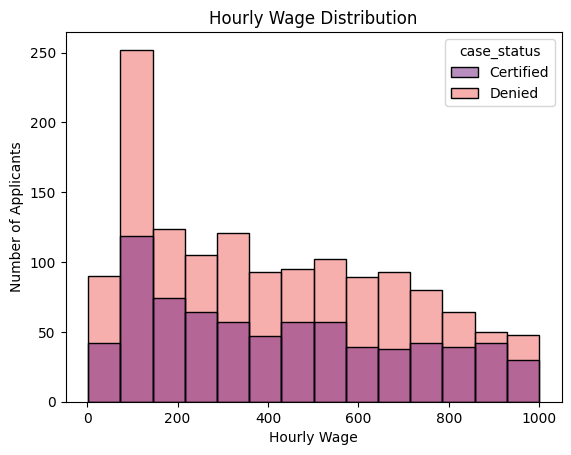

In [30]:
# create a dataframe only of workers applying for jobs with a unit_wage of 'Hour'
df_hourly = df[df.unit_of_wage=='Hour']

# show distribution of the prevailing_wage within this dataframe, and ratio of case_status within each bin
sns.histplot(data=df_hourly, x='prevailing_wage', hue='case_status', palette='magma')
plt.xlabel('Hourly Wage')
plt.ylabel('Number of Applicants')
plt.title('Hourly Wage Distribution')
plt.show()

In [31]:
# create bins to categorize applicants by the per-day wage of the job they are applying for
bins = list(np.arange(0,1100,200))

# assign each applicant to a category and show the counts
df_hourly['income_per_day'] = pd.cut(df_hourly['prevailing_wage'], bins)
df_hourly.groupby('income_per_day')['case_status'].value_counts()

income_per_day  case_status
(0, 200]        Denied         446
                Certified      219
(200, 400]      Denied         300
                Certified      166
(400, 600]      Denied         274
                Certified      144
(600, 800]      Denied         238
                Certified      116
(800, 1000]     Denied         148
                Certified      102
Name: case_status, dtype: int64

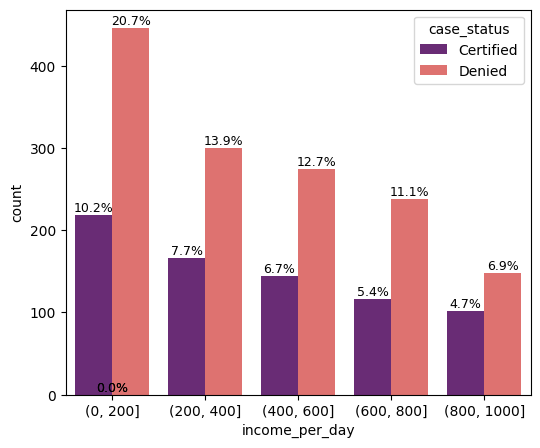

In [32]:
# create a plot of the above data, include percent of each group within the total number of cases
labeled_barplot(df_hourly,'income_per_day','case_status',perc=True,order=None)

* As depicted in the above graphs, within the pool of applicants for positions with an 'Hour' prevailing wage, the ratio of approved to denied applications increases significantly as the prevailing wage increases. However, even within the highest `income_per_day` category, an application is still more prone to denial than approval.

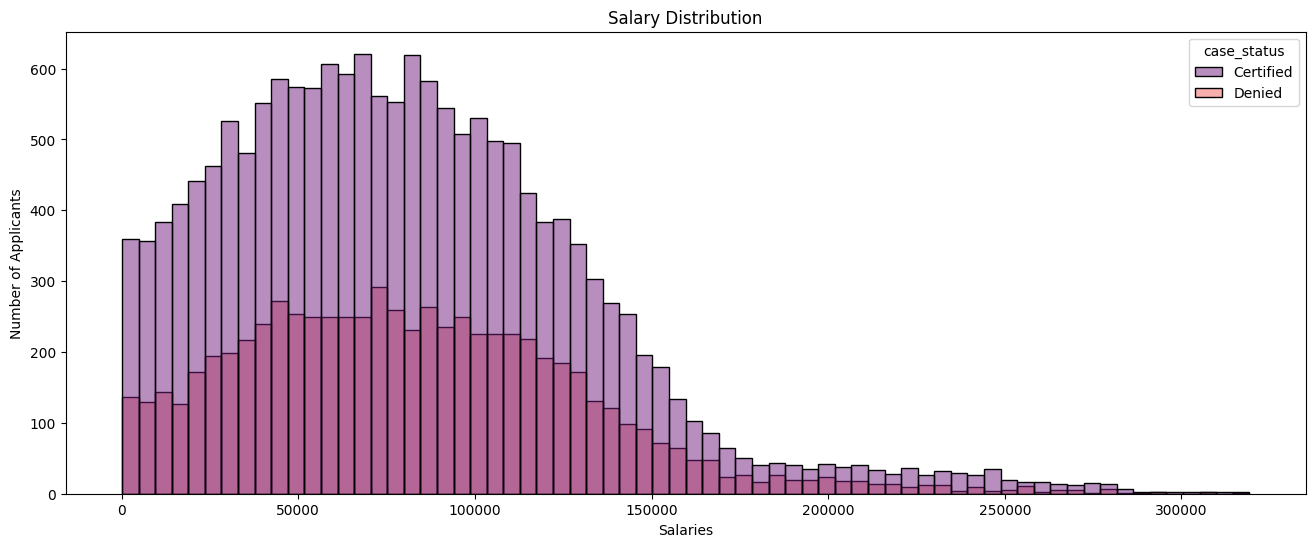

In [33]:
# create a new dataframe of only applicants applying for salaried jobs
df_annual = df[df.unit_of_wage != "Hour"]

# show distribution of annual salaries, and ratio of case_status within each bin
plt.figure(figsize=(16,6))
sns.histplot(data=df_annual, x='prevailing_wage', hue='case_status', palette='magma')
plt.xlabel('Salaries')
plt.ylabel('Number of Applicants')
plt.title('Salary Distribution')
plt.show()

* The distribution of salaries is right skewed which is logical, and a long tail of jobs can be observed with annual salaries above 150,000 dollars.
* One interesting thing to note is that the ratio of approved to denied applications remains approximately equivalent across this wide range of wages.

In [34]:
# create bins to categorize jobs by annual salary
bins = [0,25000,50000,75000,100000,125000,np.inf]
names = ['$0-25k','$25k-50k','$50k-75k','$75k-100k','$100k-125k','$125k+']

# assign each applicant a category
df_annual['income_per_year'] = pd.cut(df_annual['prevailing_wage'], bins, labels=names)
df_annual.groupby('income_per_year')['case_status'].value_counts()

income_per_year  case_status
$0-25k           Certified      2089
                 Denied          759
$25k-50k         Certified      2835
                 Denied         1232
$50k-75k         Certified      3132
                 Denied         1371
$75k-100k        Certified      3011
                 Denied         1315
$100k-125k       Certified      2405
                 Denied         1138
$125k+           Certified      2782
                 Denied         1225
Name: case_status, dtype: int64

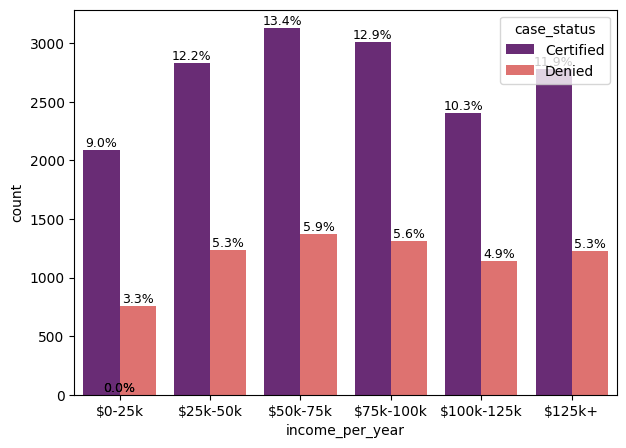

In [35]:
# create a plot of the above data, include percent of each group within the total number of cases
labeled_barplot(df_annual,'income_per_year','case_status',perc=True,order=None)

* Supporting the observation mentioned earlier, there seems to be no notable shift in the ratio of approved to denied applications with an increase in `income_per_year`. But on the contrary, this ratio might actually decline as the `prevailing_wage` rises.

* When observing applications to a job with an `income_per_year` wage, the greatest concentration is seen for positions offering salaries between 50,000 and 75,000 dollars per year.

## Revisiting EDA for int64

In [36]:
# print summary statistics of all int64 variables
df.describe(include = ['int64']).T

,count,mean,std,min,25%,50%,75%,max
no_of_employees,25447.00,5674.42,22891.84,12.00,1025.00,2112.00,3506.50,602069.00
yr_of_estab,25447.00,1979.39,42.39,1800.00,1976.00,1997.00,2005.00,2016.00


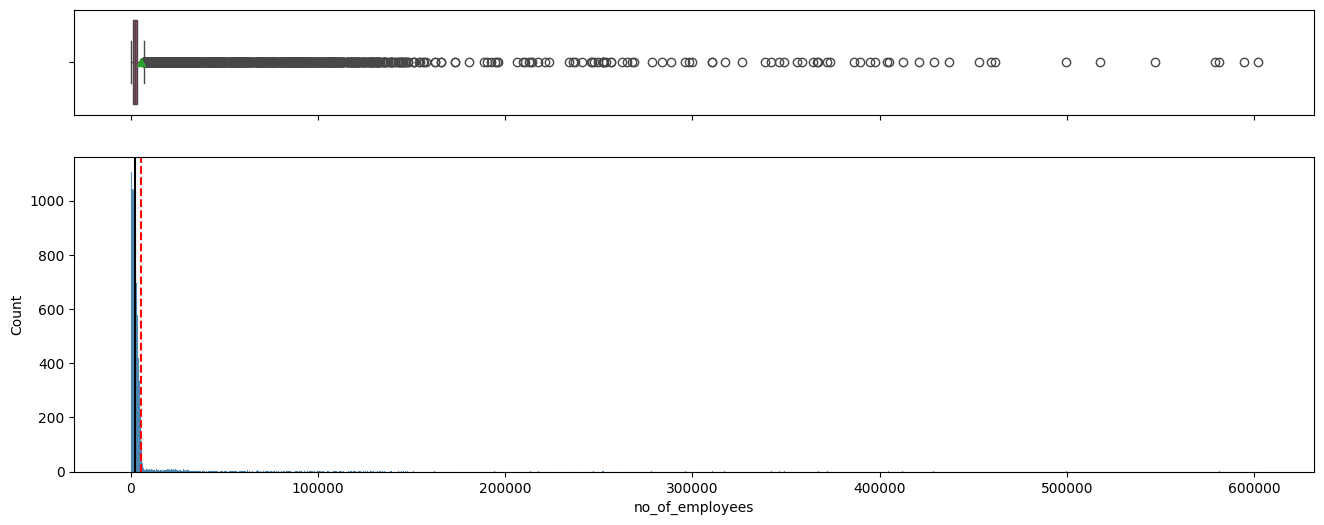

In [37]:
# create histogram and boxplots for row 1
histogram_boxplot(df, 'no_of_employees')

* The data and accompanying graphs above illustrate that the distribution of companies by number of employees is heavily skewed to the right, yet suspiciously do not have outlier values, warranting further scrutiny.

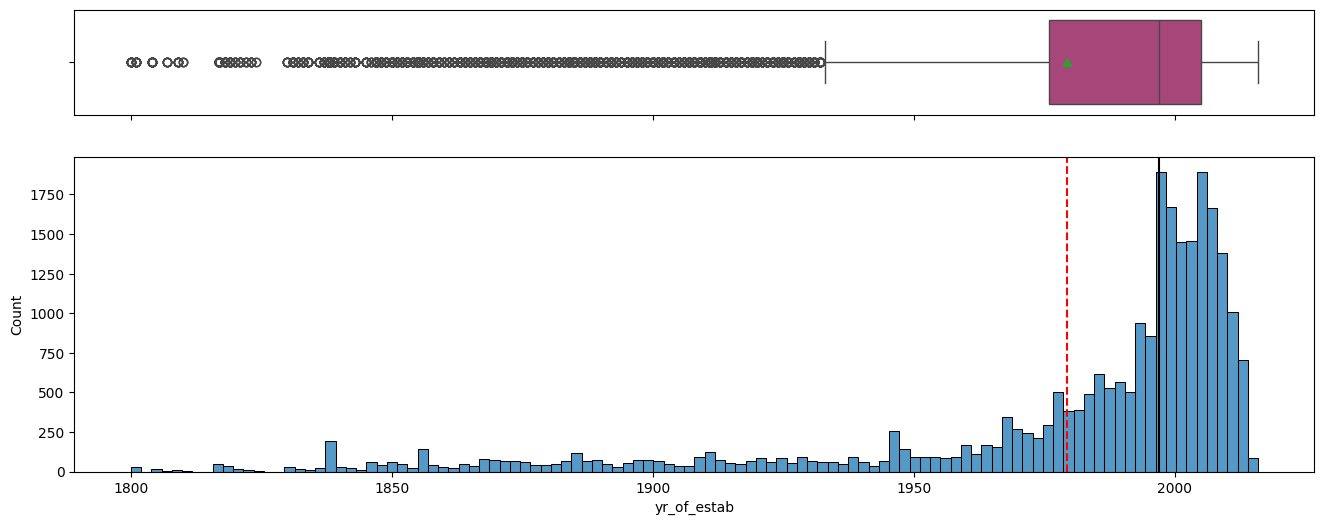

In [38]:
# create histogram and boxplots for row 2
histogram_boxplot(df, 'yr_of_estab')

* The data and accompanying graphs above illustrate that the distribution of companies by their year of establishment is heavily skewed to the left, yet suspiciously do not have outlier values, warranting further scrutiny.

## Revisiting EDA for float64

In [39]:
# print summary statistics of all float64 variables
df_annual.describe(include = ['float64']).T

,count,mean,std,min,25%,50%,75%,max
prevailing_wage,23294.00,81312.84,49943.37,100.00,43860.93,76257.68,111414.45,319210.27


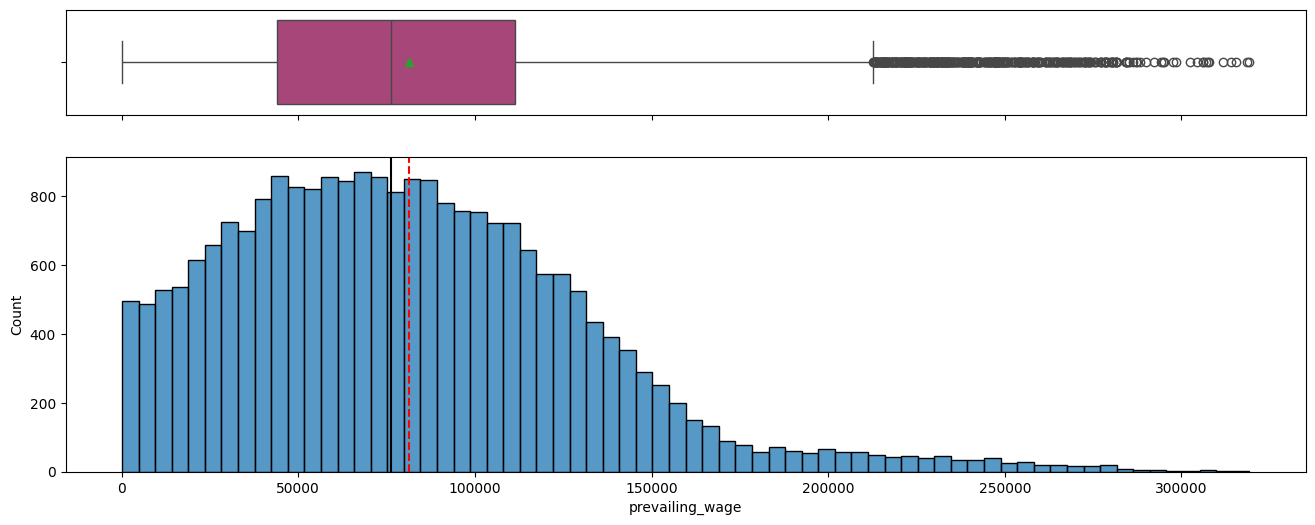

In [40]:
# create histogram and boxplots annual wages
histogram_boxplot(df_annual,'prevailing_wage')

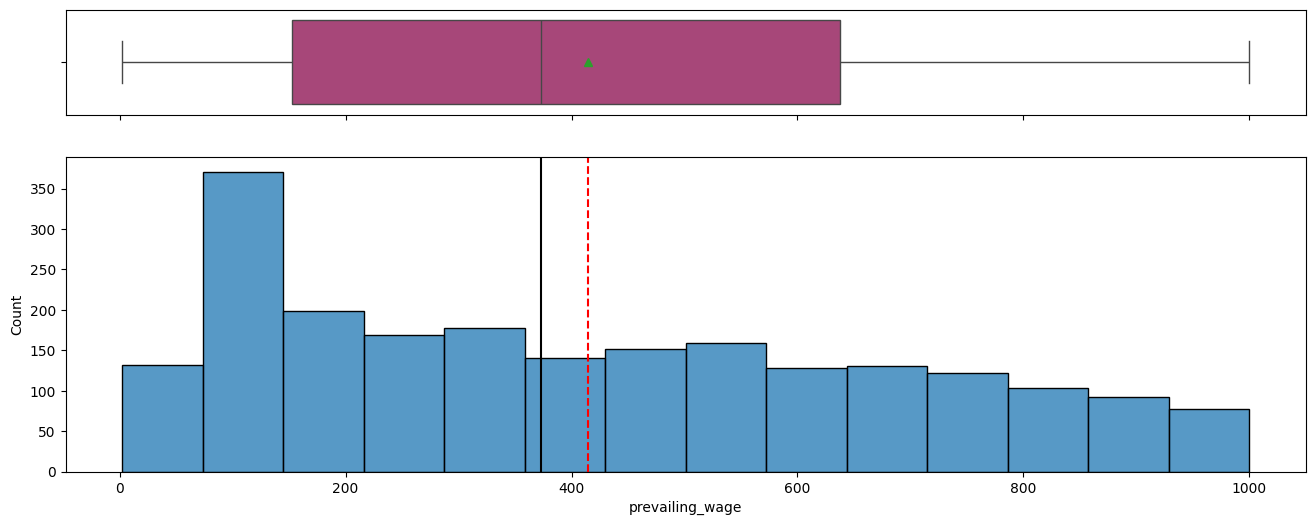

In [41]:
# create histogram and boxplots for hourly wages
histogram_boxplot(df_hourly,'prevailing_wage')

## Bivariate Analysis

continent    Africa   Asia  Europe  North America  Oceania  South America  \
case_status                                                                 
All             550  16840    3727           3287      192            851   
Certified       396  11001    2953           2037      122            492   
Denied          154   5839     774           1250       70            359   

continent      All  
case_status         
All          25447  
Certified    17001  
Denied        8446  
------------------------------------------------------------------------------------------------------------------------


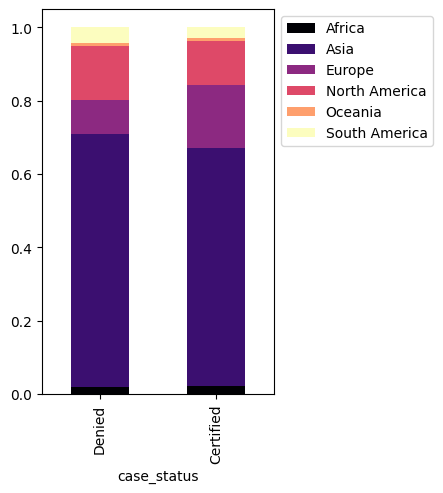

education_of_employee  Bachelor's  Doctorate  High School  Master's    All
case_status                                                               
All                         10220       2189         3416      9622  25447
Certified                    6362       1910         1164      7565  17001
Denied                       3858        279         2252      2057   8446
------------------------------------------------------------------------------------------------------------------------


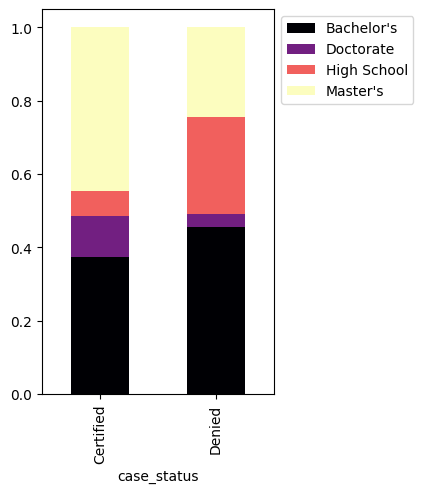

has_job_experience      N      Y    All
case_status                            
All                 10661  14786  25447
Certified            5986  11015  17001
Denied               4675   3771   8446
------------------------------------------------------------------------------------------------------------------------


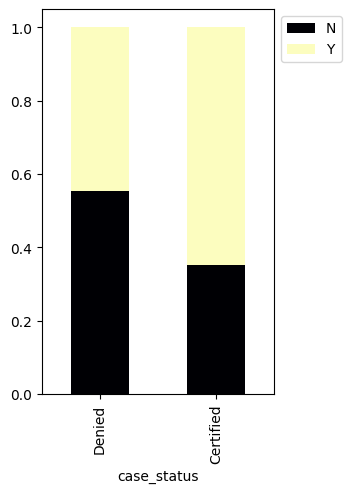

requires_job_training      N     Y    All
case_status                              
All                    22498  2949  25447
Certified              15000  2001  17001
Denied                  7498   948   8446
------------------------------------------------------------------------------------------------------------------------


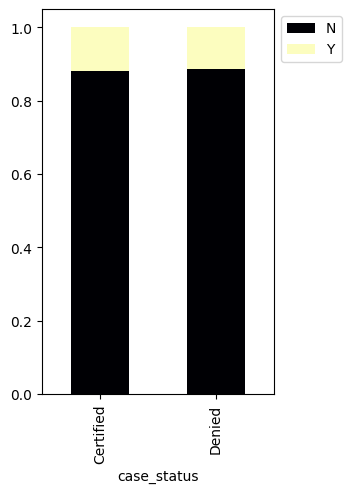

region_of_employment  Island  Midwest  Northeast  South  West    All
case_status                                                         
All                      375     4299       7189   7006  6578  25447
Certified                226     3246       4524   4908  4097  17001
Denied                   149     1053       2665   2098  2481   8446
------------------------------------------------------------------------------------------------------------------------


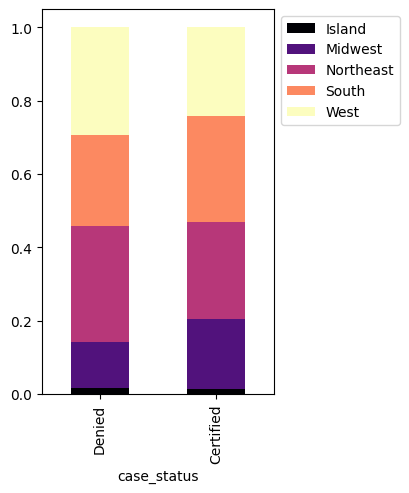

unit_of_wage  Hour  Month  Week   Year    All
case_status                                  
All           2153     89   272  22933  25447
Certified      747     55   169  16030  17001
Denied        1406     34   103   6903   8446
------------------------------------------------------------------------------------------------------------------------


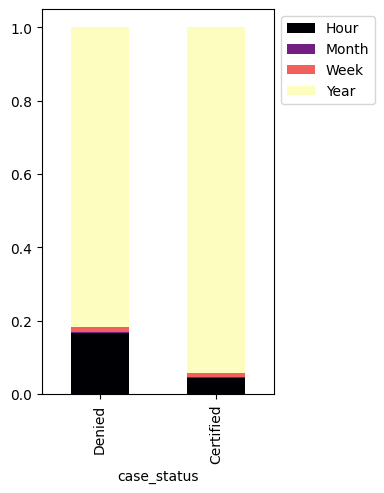

full_time_position     N      Y    All
case_status                           
All                 2706  22741  25447
Certified           1855  15146  17001
Denied               851   7595   8446
------------------------------------------------------------------------------------------------------------------------


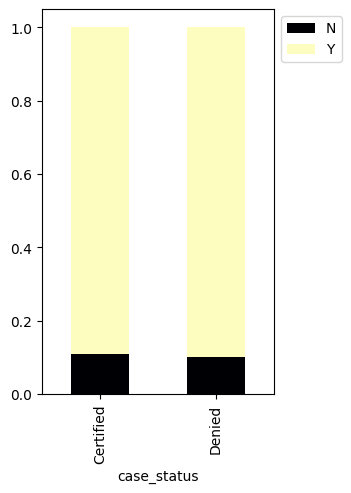

case_status  Certified  Denied    All
case_status                          
Denied               0    8446   8446
All              17001    8446  25447
Certified        17001       0  17001
------------------------------------------------------------------------------------------------------------------------


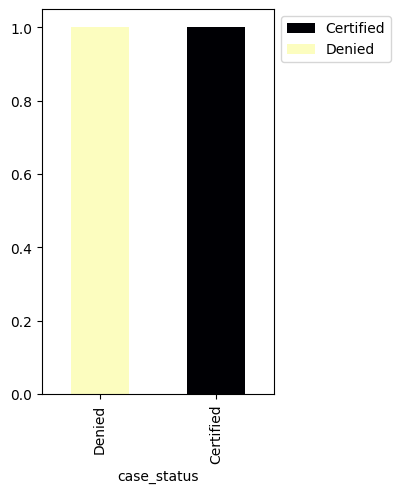

company_size  0-1000  1000-2000  2000-3000  3000-4000  4000+    All
case_status                                                        
All             6208       5915       4978       3548   4798  25447
Certified       4091       3878       3330       2341   3361  17001
Denied          2117       2037       1648       1207   1437   8446
------------------------------------------------------------------------------------------------------------------------


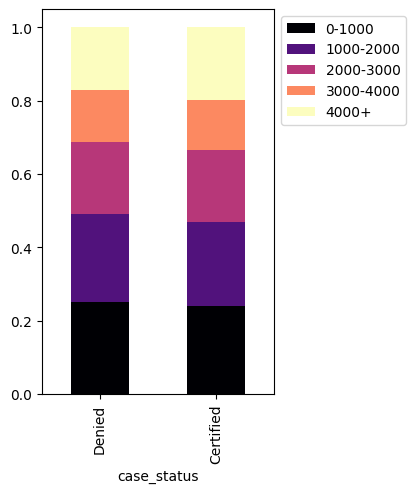

company_age   50+  30-50  20-30  10-20  0-10    All
case_status                                        
All          5106   3739   3386   8367  4849  25447
Certified    3385   2466   2226   5567  3357  17001
Denied       1721   1273   1160   2800  1492   8446
------------------------------------------------------------------------------------------------------------------------


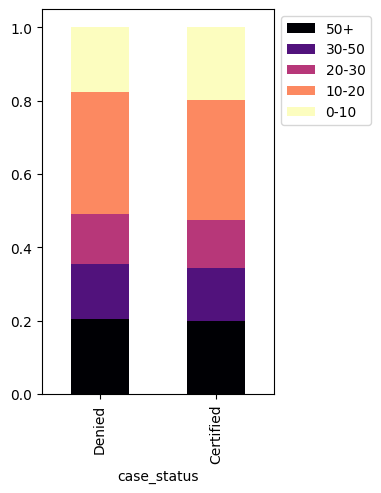

In [42]:
# create table and stacked barplot for each variable with a data type of category by case_status
cols_cat = df.select_dtypes(['category'])
for i in cols_cat.columns:
    stacked_barplot(df, "case_status", i)

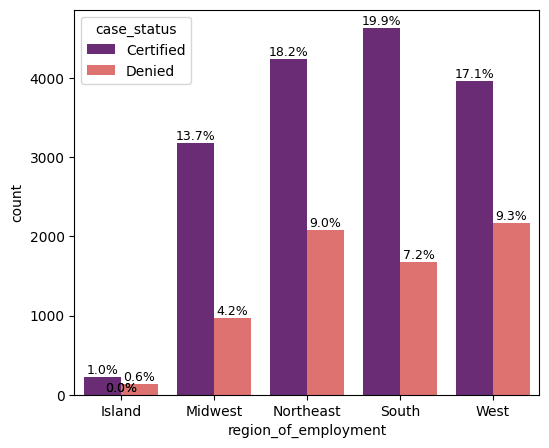

In [43]:
# create barplot per region of employment for an applicant's job with relevant percent of approved and denied cases
labeled_barplot(df_annual,'region_of_employment','case_status',perc=True,order=None)

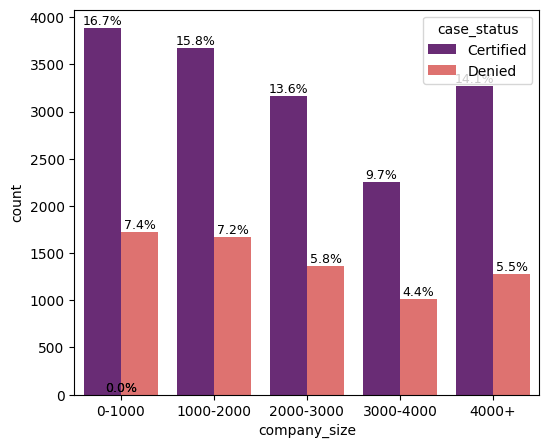

In [44]:
# create barplot for size of the company an applicant is applying for with relevant percent of approved and denied cases
labeled_barplot(df_annual,'company_size','case_status',perc=True,order=None)

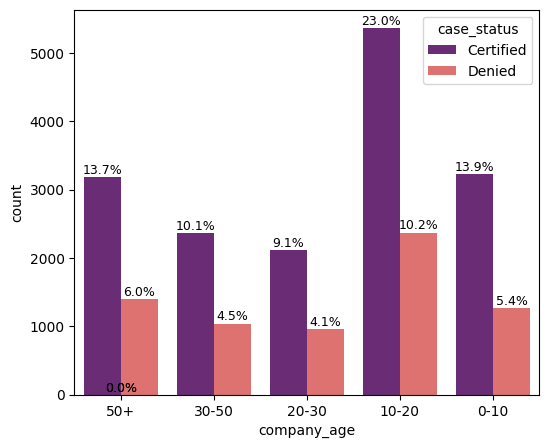

In [45]:
# create barplot per region of employment for applicant's job with relevant percent of approved and denied cases
labeled_barplot(df_annual,'company_age','case_status',perc=True,order=None)

In [46]:
# print tables listing mean wage for each unique value within each variable with dtype category
for col in df_annual.dtypes[df_annual.dtypes == 'category'].index:
    print(df_annual.groupby(col)['prevailing_wage'].mean())
    print(" ")

continent
Africa          82817.44
Asia            86237.72
Europe          62148.78
North America   80015.78
Oceania         83806.39
South America   73641.62
Name: prevailing_wage, dtype: float64
 
education_of_employee
Bachelor's    81153.74
Doctorate     67498.27
High School   80905.55
Master's      84849.96
Name: prevailing_wage, dtype: float64
 
has_job_experience
N   86478.62
Y   77881.05
Name: prevailing_wage, dtype: float64
 
requires_job_training
N   80867.28
Y   84473.58
Name: prevailing_wage, dtype: float64
 
region_of_employment
Island      96323.02
Midwest     94900.09
Northeast   77091.74
South       82174.41
West        74720.82
Name: prevailing_wage, dtype: float64
 
unit_of_wage
Hour         NaN
Month   87592.86
Week    85606.82
Year    81237.54
Name: prevailing_wage, dtype: float64
 
full_time_position
N   105484.60
Y    78161.02
Name: prevailing_wage, dtype: float64
 
case_status
Certified   80816.02
Denied      82459.91
Name: prevailing_wage, dtype: float64
 
compa

In [47]:
# print tables listing mean wage for each unique value within each variable with dtype category
for col in df_hourly.dtypes[df_hourly.dtypes == 'category'].index:
    print(df_hourly.groupby(col)['prevailing_wage'].mean())
    print(" ")

continent
Africa          399.13
Asia            421.97
Europe          398.23
North America   406.39
Oceania         477.20
South America   392.17
Name: prevailing_wage, dtype: float64
 
education_of_employee
Bachelor's    413.02
Doctorate     414.55
High School   418.06
Master's      415.42
Name: prevailing_wage, dtype: float64
 
has_job_experience
N   414.31
Y   415.57
Name: prevailing_wage, dtype: float64
 
requires_job_training
N   415.88
Y   382.34
Name: prevailing_wage, dtype: float64
 
region_of_employment
Island      275.65
Midwest     427.30
Northeast   406.65
South       426.43
West        413.82
Name: prevailing_wage, dtype: float64
 
unit_of_wage
Hour    414.77
Month      NaN
Week       NaN
Year       NaN
Name: prevailing_wage, dtype: float64
 
full_time_position
N   488.47
Y   414.12
Name: prevailing_wage, dtype: float64
 
case_status
Certified   424.92
Denied      409.38
Name: prevailing_wage, dtype: float64
 
company_size
0-1000      391.91
1000-2000   433.71
2000-3000 

* Based on the ratio of approved to denied applications when looking at continent, education, prior experience, prevailing wage, and unit of wage:

    - The requirement of training for a job does not impact the ratio.
    - Whether a job is full-time or not does not affect the ratio.
    - Applicants in the Midwest or South region tend to have a higher ratio of approvals compared to those in the Northeast, West, and notably the Island region.
    - Jobs applied for by applicants with a doctorate degree have the lowest mean prevailing wage among all education levels.
    - Temporary positions show a notably higher prevailing wage compared to full time positions.

## Data Preprocessing

In [48]:
# dropping int64 columns from the dataset, since info is captured through the features engineered above
df_model = df.drop(labels=['no_of_employees','yr_of_estab'], axis=1, inplace=True)

In [49]:
# encoding certified as 1 and denied as 0
df["case_status"] = df["case_status"].apply(lambda x: 1 if x == "Certified" else 0)

## Splitting Data

In [50]:
# create dataframe for the predictor feature columns
X = df.drop('case_status',axis=1)

# create datafrane for the predicted class (1=True, 0=False)
Y = df['case_status']

# generate dummy variables for each categorical variable
X = pd.get_dummies(X, drop_first=True)

# split the data into train and test datasets
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=1)

In [51]:
# confirm data has split
print("{0:0.2f}% of the data is in training set".format((len(x_train)/len(df.index)) * 100))
print("{0:0.2f}% of the data is in testing set".format((len(x_test)/len(df.index)) * 100))

70.00% of the data is in training set
30.00% of the data is in testing set


In [52]:
# confirm the shape of both data sets and the ratio of classes is the same across both train and test datasets
print("Shape of Training set : ", x_train.shape)
print("Shape of Testing set : ", x_test.shape)
print(' ')
print("Percentage of classes in training set:")
print(y_train.value_counts(normalize=True))
print(' ')
print("Percentage of classes in testing set:")
print(y_test.value_counts(normalize=True))

Shape of Training set :  (17812, 27)
Shape of Testing set :  (7635, 27)
 
Percentage of classes in training set:
1   0.67
0   0.33
Name: case_status, dtype: float64
 
Percentage of classes in testing set:
1   0.67
0   0.33
Name: case_status, dtype: float64


## Model Building

**Note**

1. Sample parameter grids have been provided to do necessary hyperparameter tuning. These sample grids are expected to provide a balance between model performance improvement and execution time. One can extend/reduce the parameter grid based on execution time and system configuration.
  - Please note that if the parameter grid is extended to improve the model performance further, the execution time will increase

- For Gradient Boosting:

```
param_grid = {
    "init": [AdaBoostClassifier(random_state=1),DecisionTreeClassifier(random_state=1)],
    "n_estimators": np.arange(50,110,25),
    "learning_rate": [0.01,0.1,0.05],
    "subsample":[0.7,0.9],
    "max_features":[0.5,0.7,1],
}
```

- For Adaboost:

```
param_grid = {
    "n_estimators": np.arange(50,110,25),
    "learning_rate": [0.01,0.1,0.05],
    "base_estimator": [
        DecisionTreeClassifier(max_depth=2, random_state=1),
        DecisionTreeClassifier(max_depth=3, random_state=1),
    ],
}
```

- For Bagging Classifier:

```
param_grid = {
    'max_samples': [0.8,0.9,1],
    'max_features': [0.7,0.8,0.9],
    'n_estimators' : [30,50,70],
}
```
- For Random Forest:

```
param_grid = {
    "n_estimators": [50,110,25],
    "min_samples_leaf": np.arange(1, 4),
    "max_features": [np.arange(0.3, 0.6, 0.1),'sqrt'],
    "max_samples": np.arange(0.4, 0.7, 0.1)
}
```

- For Decision Trees:

```
param_grid = {
    'max_depth': np.arange(2,6),
    'min_samples_leaf': [1, 4, 7],
    'max_leaf_nodes' : [10, 15],
    'min_impurity_decrease': [0.0001,0.001]
}
```

- For XGBoost:

```
param_grid={'n_estimators':np.arange(50,110,25),
            'scale_pos_weight':[1,2,5],
            'learning_rate':[0.01,0.1,0.05],
            'gamma':[1,3],
            'subsample':[0.7,0.9]
}
```

### Model evaluation criterion

Model can make wrong predictions in the following scenarios:

* If it predicts that an applicant should be approved, yet the applicant is denied.
* If it predicts that an applicant should be denied, yet the applicant is approved.

Which case is more important?

Both are important:
* If an applicant is approved although they do not meet the criteria for approval, a position that should have been occupied by a US citizen may be taken by someone unqualified.
* If an applicant is denied although they meet the criteria for approval, American companies may struggle to fill essential roles, potentially reducing overall productivity in the economy.

How to reduce losses?

* Since reviewing each application requires significant time and resources, the model should promptly identify candidates predicted for approval, allowing agents to prioritize these applications.
* The F1 Score serves as a suitable metric for evaluating the model's performance, as a higher F1 score indicates a better balance in minimizing both False Negatives and False Positives.
* Where applicable, balanced class weights can be applied, to ensure the model equally prioritizes both classes.

In [60]:
# function to compute different metrics (accuracy, recall, precision) to check performance of classification model built using sklearn
def model_performance_classification_sklearn(model, predictors, target):
    """
    Function to compute different metrics to check classification model performance

    model: classifier
    predictors: independent variables
    target: dependent variable
    """

    # predicting using the independent variables
    pred = model.predict(predictors)

    acc = accuracy_score(target, pred)  # to compute Accuracy
    recall = recall_score(target, pred)  # to compute Recall
    precision = precision_score(target, pred)  # to compute Precision
    f1 = f1_score(target, pred)  # to compute F1-score

    # creating a dataframe of metrics
    df_perf = pd.DataFrame(
        {
            "Accuracy": acc,
            "Recall": recall,
            "Precision": precision,
            "F1": f1,
        },
        index=[0],
    )

    return df_perf

In [75]:
def confusion_matrix_sklearn(model, predictors, target):
    """
    Plot the confusion matrix with percentages.

    model: classifier
    predictors: independent variables
    target: dependent variable
    """
    y_pred = model.predict(predictors)
    cm = confusion_matrix(target, y_pred)
    total_samples = cm.sum()

    # Calculate percentages and format the labels
    labels = np.asarray([
        ["{0:0.0f}\n({1:.2%})".format(cm[i, j], cm[i, j] / total_samples)]
        for i in range(cm.shape[0]) for j in range(cm.shape[1])
    ]).reshape(cm.shape)

    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=labels, fmt="", cmap='Reds')
    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    plt.title("Confusion Matrix")
    plt.show()

### Decision Tree

In [76]:
# build model using the DecisionTreeClassifier function, using default 'gini' criteria to split
dtree = DecisionTreeClassifier(criterion='gini', random_state=1, class_weight='balanced')

In [77]:
dtree.fit(x_train, y_train)

DecisionTreeClassifier(class_weight='balanced', random_state=1)

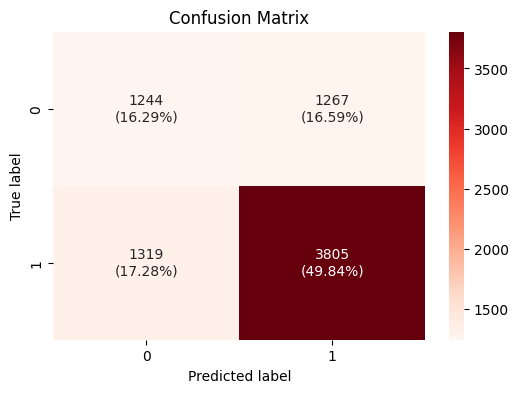

In [78]:
# visualize perfomance via confusion matrix 
confusion_matrix_sklearn(dtree, x_test, y_test)

True Positive: approved applicant and model predicted approved → (observed=1, predicted=1)

False Positive: denied applicant and model predicted approved → (observed=0, predicted=1)

True Negative: denied applicant and model predicted denied → (observed=0, predicted=0)

False Negative: approved applicant and model predicted denied → (observed=1,predicted=0)

In [109]:
dtree_model_train_perf=model_performance_classification_sklearn(dtree, x_train, y_train)
print("Training performance \n",dtree_model_train_perf)
dtree_model_test_perf=model_performance_classification_sklearn(dtree, x_test, y_test)
print("Testing performance \n",dtree_model_test_perf)

Training performance 
    Accuracy  Recall  Precision   F1
0      1.00    1.00       1.00 1.00
Testing performance 
    Accuracy  Recall  Precision   F1
0      0.66    0.74       0.75 0.75


* The Decision Tree model demonstrates strong performance on the training set however, it fails to generalize effectively to the testing set, suggesting potential overfitting.

### Bagging Classifier

In [81]:
bagging = BaggingClassifier(random_state=1)
bagging.fit(x_train,y_train)

BaggingClassifier(random_state=1)

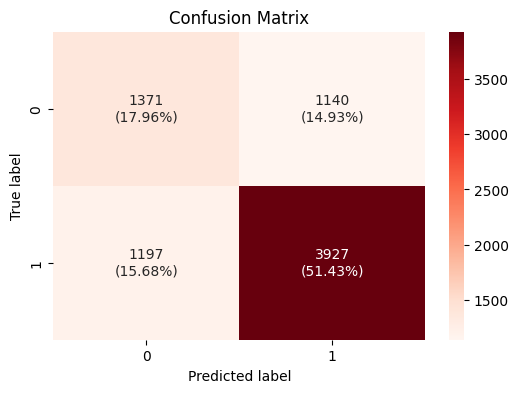

In [82]:
# visualize perfomance via confusion matrix
confusion_matrix_sklearn(bagging, x_test, y_test)

In [108]:
bagging_model_train_perf=model_performance_classification_sklearn(bagging, x_train, y_train)
print("Training performance \n",bagging_model_train_perf)
bagging_model_test_perf=model_performance_classification_sklearn(bagging, x_test, y_test)
print("Testing performance \n",bagging_model_test_perf)

Training performance 
    Accuracy  Recall  Precision   F1
0      0.98    0.98       0.99 0.99
Testing performance 
    Accuracy  Recall  Precision   F1
0      0.69    0.77       0.78 0.77


* Although exhibiting signs of overfitting to the training data, the Bagging model achieves a higher F1 score than the Decision Tree.

### Random Forest

In [85]:
rf = RandomForestClassifier(random_state=1)
rf.fit(x_train,y_train)

RandomForestClassifier(random_state=1)

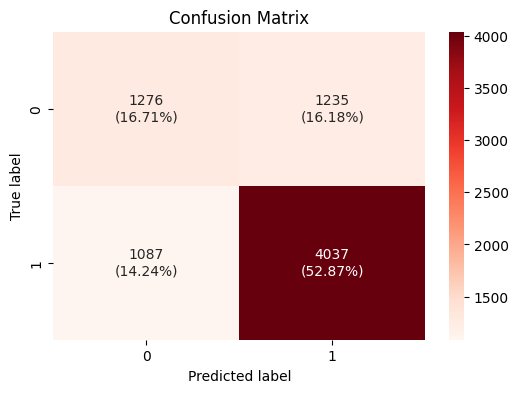

In [86]:
# visualize perfomance via confusion matrix
confusion_matrix_sklearn(rf,x_test,y_test)

In [107]:
rf_model_train_perf=model_performance_classification_sklearn(rf,x_train,y_train)
print("Training performance \n",rf_model_train_perf)
rf_model_test_perf=model_performance_classification_sklearn(rf,x_test,y_test)
print("Testing performance \n",rf_model_test_perf)

Training performance 
    Accuracy  Recall  Precision   F1
0      1.00    1.00       1.00 1.00
Testing performance 
    Accuracy  Recall  Precision   F1
0      0.70    0.79       0.77 0.78


* Similar to previous models, this Random Forest is also overfit to the training dataset but has the highest F1 score thus far.

### AdaBoost Classifier

In [89]:
ab_classifier=AdaBoostClassifier(random_state=1)
ab_classifier.fit(x_train,y_train)

AdaBoostClassifier(random_state=1)

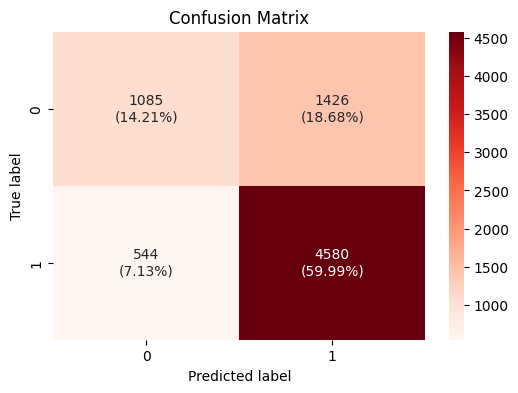

In [90]:
# visualize perfomance via confusion matrix 
confusion_matrix_sklearn(ab_classifier, x_test,y_test)

In [106]:
ab_classifier_model_train_perf = model_performance_classification_sklearn(ab_classifier,x_train,y_train)
print("Training performance \n",ab_classifier_model_train_perf)
ab_classifier_model_test_perf = model_performance_classification_sklearn(ab_classifier,x_test,y_test)
print("Testing performance \n",ab_classifier_model_test_perf)

Training performance 
    Accuracy  Recall  Precision   F1
0      0.73    0.88       0.76 0.82
Testing performance 
    Accuracy  Recall  Precision   F1
0      0.74    0.89       0.76 0.82


* The AdaBoost model demonstrates consistent performance on both the training and testing datasets, suggesting no overfitting.
* Furthermore, it outperforms all other models tested, boasting the highest F1 score on the testing data.

### Gradient Boosting Classifier

In [93]:
gbc = GradientBoostingClassifier(random_state=1)
gbc.fit(x_train,y_train)

GradientBoostingClassifier(random_state=1)

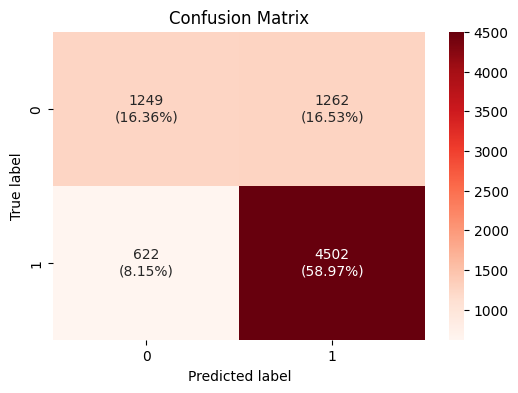

In [95]:
# visualize perfomance via confusion matrix 
confusion_matrix_sklearn(gbc, x_test,y_test)

In [105]:
gbc_classifier_model_train_perf = model_performance_classification_sklearn(gbc,x_train,y_train)
print("Training performance \n",gbc_classifier_model_train_perf)
gbc_classifier_model_test_perf = model_performance_classification_sklearn(gbc,x_test,y_test)
print("Training performance \n",gbc_classifier_model_test_perf)

Training performance 
    Accuracy  Recall  Precision   F1
0      0.75    0.87       0.78 0.83
Training performance 
    Accuracy  Recall  Precision   F1
0      0.75    0.88       0.78 0.83


* The Gradient Boosting model demonstrates consistent performance on both the training and testing datasets, suggesting no overfitting.
* Also, overall performs even better than all previous models

### XGBoost Classifier

In [98]:
xgb = XGBClassifier(random_state=1,eval_metric='logloss')
xgb.fit(x_train,y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=1, ...)

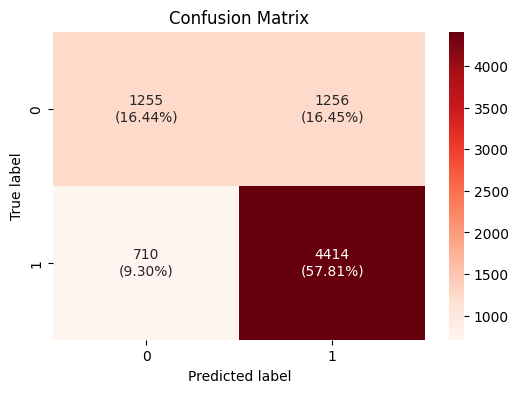

In [99]:
# visualize perfomance via confusion matrix 
confusion_matrix_sklearn(xgb, x_test,y_test)

In [104]:
xgb_classifier_model_train_perf = model_performance_classification_sklearn(xgb,x_train,y_train)
print("Training performance \n",xgb_classifier_model_train_perf)
xgb_classifier_model_test_perf = model_performance_classification_sklearn(xgb,x_test,y_test)
print("Training performance \n",xgb_classifier_model_test_perf)

Training performance 
    Accuracy  Recall  Precision   F1
0      0.81    0.91       0.83 0.87
Training performance 
    Accuracy  Recall  Precision   F1
0      0.74    0.86       0.78 0.82


* The XGBoost model demonstrates consistent performance on both the training and testing datasets, suggesting no overfitting.
* Not only the latest but also the greatest model thus far based on F1 score as compared to previous models

## Model Performance Comparison and Conclusions

In [102]:
# create a dataframe comparing the performance of the base models on the training data

models_train_comp_df = pd.concat(
    [dtree_model_train_perf.T,
     bagging_model_train_perf.T,
     rf_model_train_perf.T,
     ab_classifier_model_train_perf.T, 
     gbc_classifier_model_train_perf.T, 
     xgb_classifier_model_train_perf.T],
    axis=1,
)
models_train_comp_df.columns = [
    "Decision Tree",
    "Bagging Classifier",
    "Random Forest",
    "AdaBoost Classifier",
    "Gradient Boosting Classifier",
    "XGBoost Classifier"]
print("Training performance comparison of base models:")
models_train_comp_df

Training performance comparison of base models:


,Decision Tree,Bagging Classifier,Random Forest,AdaBoost Classifier,Gradient Boosting Classifier,XGBoost Classifier
Accuracy,1.00,0.98,1.00,0.73,0.75,0.81
Recall,1.00,0.98,1.00,0.88,0.87,0.91
Precision,1.00,0.99,1.00,0.76,0.78,0.83
F1,1.00,0.99,1.00,0.82,0.83,0.87


In [103]:
# create a dataframe comparing the performance of the base models on the testing data

models_test_comp_df = pd.concat(
    [dtree_model_test_perf.T,
     bagging_model_test_perf.T,
     rf_model_test_perf.T,
     ab_classifier_model_test_perf.T, 
     gbc_classifier_model_test_perf.T, 
     xgb_classifier_model_test_perf.T],
    axis=1,
)
models_test_comp_df.columns = [
    "Decision Tree",
    "Bagging Classifier",
    "Random Forest",
    "AdaBoost Classifier",
    "Gradient Boosting Classifier",
    "XGBoost Classifier"]
print("Testing performance comparison of base models:")
models_test_comp_df

Testing performance comparison of base models:


,Decision Tree,Bagging Classifier,Random Forest,AdaBoost Classifier,Gradient Boosting Classifier,XGBoost Classifier
Accuracy,0.66,0.69,0.70,0.74,0.75,0.74
Recall,0.74,0.77,0.79,0.89,0.88,0.86
Precision,0.75,0.78,0.77,0.76,0.78,0.78
F1,0.75,0.77,0.78,0.82,0.83,0.82


* Generally, the bagging models suffer from overfitting compared to the boosting models
* XGBoost model scored highest overall in F1, followed closely by Gradient Boosting
* Most incompatible model for this dataset is by far Decision Tree based on metric numbers

##  Will tuning the hyperparameters improve the model performance?

### Tuning Decision Tree

In [110]:
# choose the type of classifier 
dtree_estimator = DecisionTreeClassifier(random_state=1)

# grid of parameters to choose from
parameters = {'max_depth': np.arange(5,30,5),
              'min_samples_leaf': [3, 5, 7],
              'max_leaf_nodes' : [2, 4, 6],
              'min_impurity_decrease': [0.0001,0.001,0.01,0.1]
             }

# type of scoring used to compare parameter combinations
scorer = metrics.make_scorer(metrics.f1_score)

# run grid search
grid_obj = GridSearchCV(dtree_estimator, parameters, scoring=scorer, cv=5)
grid_obj = grid_obj.fit(x_train, y_train)

# set the clf to the best combination of parameters
dtree_estimator = grid_obj.best_estimator_

# fit the best algorithm to the data. 
dtree_estimator.fit(x_train, y_train)

DecisionTreeClassifier(max_depth=5, max_leaf_nodes=4,
                       min_impurity_decrease=0.0001, min_samples_leaf=3,
                       random_state=1)

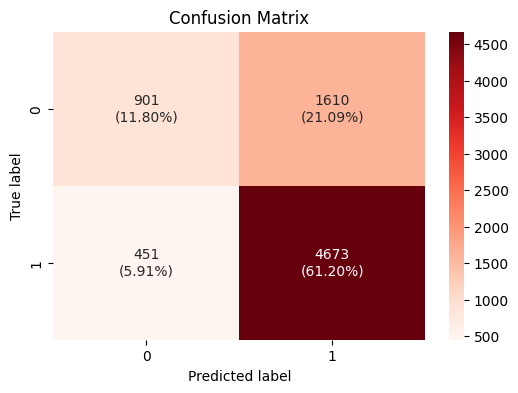

In [111]:
# visualize perfomance via confusion matrix 
confusion_matrix_sklearn(dtree_estimator, x_test,y_test)

In [112]:
dtree_estimator_model_train_perf=model_performance_classification_sklearn(dtree_estimator, x_train,y_train)
print("Training performance \n",dtree_estimator_model_train_perf)
dtree_estimator_model_test_perf=model_performance_classification_sklearn(dtree_estimator, x_test, y_test)
print("Testing performance \n",dtree_estimator_model_test_perf)

Training performance 
    Accuracy  Recall  Precision   F1
0      0.73    0.91       0.74 0.82
Testing performance 
    Accuracy  Recall  Precision   F1
0      0.73    0.91       0.74 0.82


* After tuning, the Decision Tree model performs well on training and testing data, displaying no signs of overfitting. 
* Additionally, the F1 score has increased almost 10% since tuning.

### Tuning Bagging Classifier

In [113]:
# randomized search for bagging classifier
parameters = {'max_samples': [0.7,0.8,0.9,1],
              'max_features': [0.7,0.8,0.9,1],
              'n_estimators' : np.arange(50, 100, 10)
             }

#run randomized search
rand_bag = RandomizedSearchCV(BaggingClassifier(random_state=1,bootstrap=True), 
                              parameters, scoring = 'f1', cv = 5, random_state=1)
rand_bag = rand_bag.fit(x_train, y_train)

# set the clf to the best combination of parameters
bag_tuned = rand_bag.best_estimator_

# fit the best algorithm to the data
bag_tuned.fit(x_train, y_train)

BaggingClassifier(max_features=0.8, max_samples=0.8, n_estimators=70,
                  random_state=1)

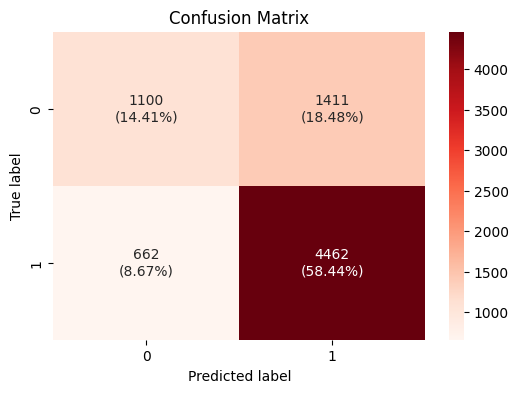

In [114]:
# visualize perfomance via confusion matrix 
confusion_matrix_sklearn(bag_tuned, x_test,y_test)

In [115]:
bagging_estimator_model_train_perf=model_performance_classification_sklearn(bag_tuned, x_train,y_train)
print("Training performance \n",bagging_estimator_model_train_perf)
bagging_estimator_model_test_perf=model_performance_classification_sklearn(bag_tuned, x_test, y_test)
print("Testing performance \n",bagging_estimator_model_test_perf)

Training performance 
    Accuracy  Recall  Precision   F1
0      0.99    1.00       0.99 0.99
Testing performance 
    Accuracy  Recall  Precision   F1
0      0.73    0.87       0.76 0.81


* The inconsistency observed between performance metrics in the training and testing set strongly suggest model is suffering from overfitting.
* Though, when compared to base model, the tuned model does perform slightly better on the testing set.

### Tuning AdaBoost

In [121]:
# choose the type of classifier 
abc_tuned = AdaBoostClassifier(random_state=1)

# grid of parameters to choose from
## add from article
parameters = {
    # let's try different max_depth for estimator
    "estimator":[DecisionTreeClassifier(max_depth=1, random_state=1, class_weight='balanced'),
                      DecisionTreeClassifier(max_depth=2, random_state=1, class_weight='balanced'),
                      DecisionTreeClassifier(max_depth=3, random_state=1, class_weight='balanced')],
    "n_estimators": np.arange(10,110,10),
    "learning_rate":np.arange(0.1,2,0.1)
}

# type of scoring used to compare parameter combinations
acc_scorer = metrics.make_scorer(metrics.f1_score)

# run randomized search
rand_abc = RandomizedSearchCV(abc_tuned, parameters, scoring=acc_scorer,cv=5, n_jobs=-1, random_state=1)
rand_abc = rand_abc.fit(x_train, y_train)

# set the clf to the best combination of parameters
abc_tuned = rand_abc.best_estimator_

# fit the best algorithm to the data.
abc_tuned.fit(x_train, y_train)

AdaBoostClassifier(estimator=DecisionTreeClassifier(class_weight='balanced',
                                                    max_depth=1,
                                                    random_state=1),
                   learning_rate=0.5, n_estimators=20, random_state=1)

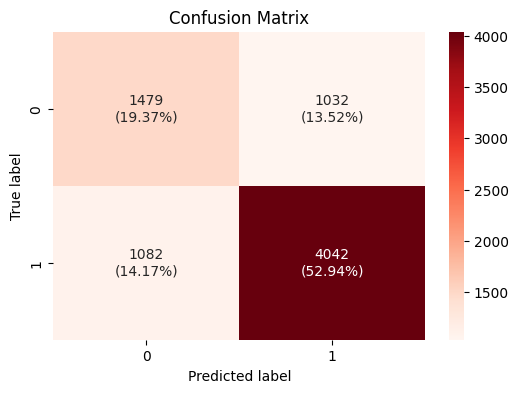

In [118]:
# visualize perfomance via confusion matrix 
confusion_matrix_sklearn(abc_tuned, x_test,y_test)

In [119]:
abc_tuned_model_train_perf=model_performance_classification_sklearn(abc_tuned, x_train,y_train)
print("Training performance \n",abc_tuned_model_train_perf)
abc_tuned_model_test_perf=model_performance_classification_sklearn(abc_tuned, x_test, y_test)
print("Testing performance \n",abc_tuned_model_test_perf)

Training performance 
    Accuracy  Recall  Precision   F1
0      0.72    0.78       0.79 0.79
Testing performance 
    Accuracy  Recall  Precision   F1
0      0.72    0.79       0.80 0.79


* Just like in the base model, AdaBoost model is not overfitting data but it performed worse after tuning.

### Tuning Gradient Boosting

In [120]:
# choose the type of classifier 
gb_tuned = GradientBoostingClassifier(random_state=1)

# grid of parameters to choose from
parameters = {"n_estimators": [150,200,250,300],
              "subsample":[0.8,0.9,1],
              "max_features":[0.7,0.8,0.9,1],
              "learning_rate": np.arange(0.1, 0.4, 0.1)}

# type of scoring used to compare parameter combinations
scorer = metrics.make_scorer(metrics.f1_score)

# run randomized search
rand_gb = RandomizedSearchCV(gb_tuned, parameters, scoring=scorer,cv=5, n_jobs=-1, random_state=1)
rand_gb = rand_gb.fit(x_train, y_train)

# set the clf to the best combination of parameters
gb_tuned = rand_gb.best_estimator_

# fit the best algorithm to the data 
gb_tuned.fit(x_train, y_train)

GradientBoostingClassifier(max_features=0.7, n_estimators=300, random_state=1,
                           subsample=1)

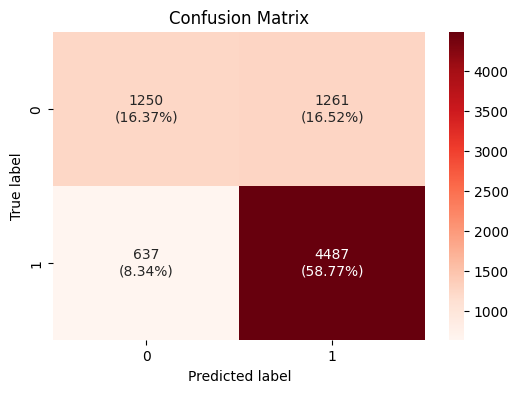

In [122]:
# visualize perfomance via confusion matrix 
confusion_matrix_sklearn(gb_tuned, x_test,y_test)

In [125]:
gb_tuned_model_train_perf=model_performance_classification_sklearn(rf_estimator, x_train,y_train)
print("Training performance \n",gb_tuned_model_train_perf)
gb_tuned_model_test_perf=model_performance_classification_sklearn(rf_estimator, x_test, y_test)
print("Testing performance \n",gb_tuned_model_test_perf)

Training performance 
    Accuracy  Recall  Precision   F1
0      0.73    0.91       0.74 0.82
Testing performance 
    Accuracy  Recall  Precision   F1
0      0.73    0.91       0.74 0.82


* Before and after tuning, the GradientBoosting model showed no signs of overfitting. 
* Before and after tuning, model's F1 score remained almost the same, with great overall performance

### Tuning Random Forest

In [126]:
# choose the type of classifier 
rf_estimator = RandomForestClassifier(random_state=1)

# grid of parameters to choose from
parameters = {"n_estimators": np.arange(10, 40, 10),
              "min_samples_leaf": np.arange(5, 10),
              "min_samples_split": [3, 5, 7],
              "max_features": ["sqrt", "log2"],
              "max_samples": np.arange(0.3, 0.7, 0.1),
}

# run randomized search
rand_rf = RandomizedSearchCV(rf_estimator, parameters, scoring='f1', cv=5, n_jobs=-1, random_state=1)
rand_rf = grid_obj.fit(x_train, y_train)

# set the clf to the best combination of parameters
rf_estimator = rand_rf.best_estimator_

# fit the best algorithm to the data 
rf_estimator.fit(x_train, y_train)

DecisionTreeClassifier(max_depth=5, max_leaf_nodes=4,
                       min_impurity_decrease=0.0001, min_samples_leaf=3,
                       random_state=1)

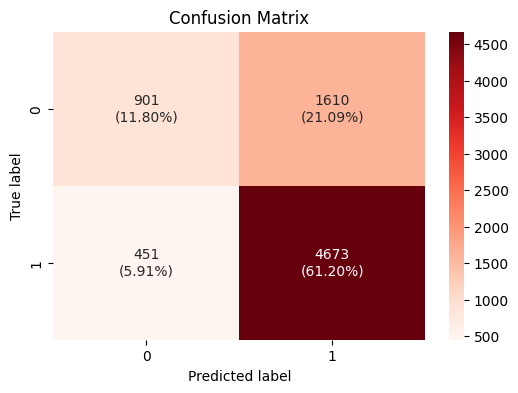

In [127]:
# visualize performance via confusion matrix
confusion_matrix_sklearn(rf_estimator, x_test,y_test)

In [128]:
rf_estimator_model_train_perf=model_performance_classification_sklearn(rf_estimator, x_train,y_train)
print("Training performance \n",rf_estimator_model_train_perf)
rf_estimator_model_test_perf=model_performance_classification_sklearn(rf_estimator, x_test, y_test)
print("Testing performance \n",rf_estimator_model_test_perf)

Training performance 
    Accuracy  Recall  Precision   F1
0      0.73    0.91       0.74 0.82
Testing performance 
    Accuracy  Recall  Precision   F1
0      0.73    0.91       0.74 0.82


* After tuning, the Random Forest model significantly improved, both increasing in F1 score and remaining consistent across testing and training sets - indicative of no overfiting

### Tuning XGBoost

In [129]:
# choose the type of classifier 
xgb_tuned = XGBClassifier(random_state=1, eval_metric='logloss')

# Grid of parameters to choose from
parameters = {"n_estimators": np.arange(10,100,20),
              "scale_pos_weight":[0,1,2,5],
              "subsample":[0.5,0.7,0.9,1],
              "learning_rate":[0.01,0.1,0.2,0.05],
              "gamma":[0,1,3],
              "colsample_bytree":[0.5,0.7,0.9,1],
              "colsample_bylevel":[0.5,0.7,0.9,1]}

# type of scoring used to compare parameter combinations
scorer = metrics.make_scorer(metrics.f1_score)

# run randomized search
rand_xgb = RandomizedSearchCV(xgb_tuned, parameters, scoring=scorer,cv=5, n_jobs=-1, random_state=1)
rand_xgb = rand_xgb.fit(x_train, y_train)

# set the clf to the best combination of parameters
xgb_tuned = rand_xgb.best_estimator_

# fit the best algorithm to the data 
xgb_tuned.fit(x_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=0.9, colsample_bynode=None,
              colsample_bytree=0.5, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=0, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=70,
              n_jobs=None, num_parallel_tree=None, random_state=1, ...)

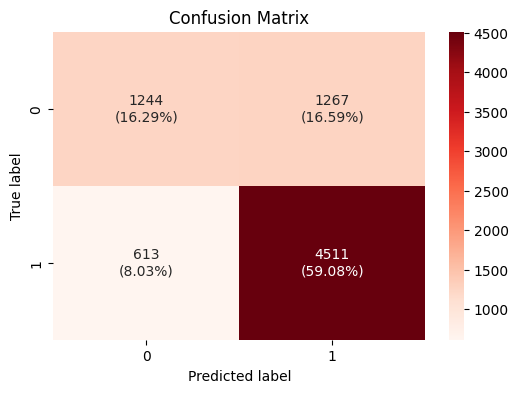

In [130]:
# visualize performance via confusion matrix
confusion_matrix_sklearn(xgb_tuned, x_test,y_test)

In [131]:
xgb_tuned_model_train_perf=model_performance_classification_sklearn(xgb_tuned, x_train,y_train)
print("Training performance \n",xgb_tuned_model_train_perf)
xgb_tuned_model_test_perf=model_performance_classification_sklearn(xgb_tuned, x_test, y_test)
print("Testing performance \n",xgb_tuned_model_test_perf)

Training performance 
    Accuracy  Recall  Precision   F1
0      0.76    0.88       0.79 0.83
Testing performance 
    Accuracy  Recall  Precision   F1
0      0.75    0.88       0.78 0.83


* After tuning my strongest model, XGBoost still avoids suffering from overfitting, but it seems though the F1 score on the Testing set had a minor increase, the Training set F1 score dropped about 0.04 points. Ovverall, tuning did not drastically change the model performance

In [133]:
# create a dataframe comparing performance of the tuned models on the training data

tuned_models_train_comp_df = pd.concat(
    [dtree_estimator_model_train_perf.T,
     bagging_estimator_model_train_perf.T,
     rf_estimator_model_train_perf.T,
     abc_tuned_model_train_perf.T, 
     gb_tuned_model_train_perf.T, 
     xgb_tuned_model_train_perf.T],
    axis=1,
)
tuned_models_train_comp_df.columns = [
    "Tuned Decision Tree",
    "Tuned Bagging Classifier",
    "Tuned Random Forest",
    "Tuned AdaBoost Classifier",
    "Tuned Gradient Boosting Classifier",
    "Tuned XGBoost Classifier"]
print("Training performance comparison of tuned models:")
tuned_models_train_comp_df

Training performance comparison of tuned models:


,Tuned Decision Tree,Tuned Bagging Classifier,Tuned Random Forest,Tuned AdaBoost Classifier,Tuned Gradient Boosting Classifier,Tuned XGBoost Classifier
Accuracy,0.73,0.99,0.73,0.72,0.73,0.76
Recall,0.91,1.00,0.91,0.78,0.91,0.88
Precision,0.74,0.99,0.74,0.79,0.74,0.79
F1,0.82,0.99,0.82,0.79,0.82,0.83


### Comparison of Tuned Models

In [134]:
# create a dataframe comparing performance of the tuned models on the testing data

tuned_models_test_comp_df = pd.concat(
    [dtree_estimator_model_test_perf.T,
     bagging_estimator_model_test_perf.T,
     rf_estimator_model_test_perf.T,
     abc_tuned_model_test_perf.T, 
     gb_tuned_model_test_perf.T, 
     xgb_tuned_model_test_perf.T],
    axis=1,
)
tuned_models_test_comp_df.columns = [
    "Tuned Decision Tree",
    "Tuned Bagging Classifier",
    "Tuned Random Forest",
    "Tuned AdaBoost Classifier",
    "Tuned Gradient Boosting Classifier",
    "Tuned XGBoost Classifier"]
print("Testing performance comparison of tuned models:")
tuned_models_test_comp_df

Testing performance comparison of tuned models:


,Tuned Decision Tree,Tuned Bagging Classifier,Tuned Random Forest,Tuned AdaBoost Classifier,Tuned Gradient Boosting Classifier,Tuned XGBoost Classifier
Accuracy,0.73,0.73,0.73,0.72,0.73,0.75
Recall,0.91,0.87,0.91,0.79,0.91,0.88
Precision,0.74,0.76,0.74,0.80,0.74,0.78
F1,0.82,0.81,0.82,0.79,0.82,0.83


In [135]:
# create a dataframe comparing performance all models on the training data
all_models_train_comp = pd.concat([models_train_comp_df,tuned_models_train_comp_df],axis=1)
all_models_train_comp.T.sort_values('F1',ascending=False)

,Accuracy,Recall,Precision,F1
Decision Tree,1.00,1.00,1.00,1.00
Random Forest,1.00,1.00,1.00,1.00
Tuned Bagging Classifier,0.99,1.00,0.99,0.99
Bagging Classifier,0.98,0.98,0.99,0.99
XGBoost Classifier,0.81,0.91,0.83,0.87
Tuned XGBoost Classifier,0.76,0.88,0.79,0.83
Gradient Boosting Classifier,0.75,0.87,0.78,0.83
Tuned Decision Tree,0.73,0.91,0.74,0.82
Tuned Random Forest,0.73,0.91,0.74,0.82
Tuned Gradient Boosting Classifier,0.73,0.91,0.74,0.82


In [137]:
'The top performing model on the training data is ' + all_models_train_comp.T.sort_values('F1',ascending=False).index[0]

'The top performing model on the training data is Decision Tree'

In [138]:
# create a dataframe comparing performance of all models on the testing data
all_models_test_comp = pd.concat([models_test_comp_df,tuned_models_test_comp_df],axis=1)
all_models_test_comp.T.sort_values('F1',ascending=False)

,Accuracy,Recall,Precision,F1
Tuned XGBoost Classifier,0.75,0.88,0.78,0.83
Gradient Boosting Classifier,0.75,0.88,0.78,0.83
AdaBoost Classifier,0.74,0.89,0.76,0.82
Tuned Decision Tree,0.73,0.91,0.74,0.82
Tuned Random Forest,0.73,0.91,0.74,0.82
Tuned Gradient Boosting Classifier,0.73,0.91,0.74,0.82
XGBoost Classifier,0.74,0.86,0.78,0.82
Tuned Bagging Classifier,0.73,0.87,0.76,0.81
Tuned AdaBoost Classifier,0.72,0.79,0.80,0.79
Random Forest,0.70,0.79,0.77,0.78


In [139]:
'The top performing model on the testing data is the ' + all_models_test_comp.T.sort_values('F1',ascending=False).index[0]

'The top performing model on the testing data is the Tuned XGBoost Classifier'

* Reviewing the results, the Decision Tree model excels on the training dataset, benefiting from its inherent tendency to overfit unless carefully pruned. Random Forest is closely following. 
* For the testing dataset, the Tuned XGBoost model achieves the most impressive F1 score of 0.83, also tied with Gradient Boosting classifier. 
* The place for second runner-ups on testing data is actually tied between five different models: AdaBoost, Tuned Decision Tree, Tuned Random Forest, and Tuned Gradient Boosting. All five models report a remarkable F1 score of 0.82. 
* Of the models that improved with tuning: XGBoost, Decision Tree, Random Forest, Bagging - the F1 scores increased only slightly on testing data.
* On the other hand, AdaBoost and Gradient Boosting both did not improve with model tuning when looking at their F1 scores.

### XGBoost Model Feature Importance

In [140]:
print(pd.DataFrame(xgb_tuned.feature_importances_, columns = ["Imp"], 
                   index = x_train.columns).sort_values(by = 'Imp', ascending = False).head(10))

                                   Imp
education_of_employee_High School 0.39
education_of_employee_Master's    0.17
has_job_experience_Y              0.10
unit_of_wage_Year                 0.06
education_of_employee_Doctorate   0.06
continent_Europe                  0.03
region_of_employment_Midwest      0.02
prevailing_wage                   0.01
full_time_position_Y              0.01
region_of_employment_West         0.01


In [141]:
feature_names = x_train.columns

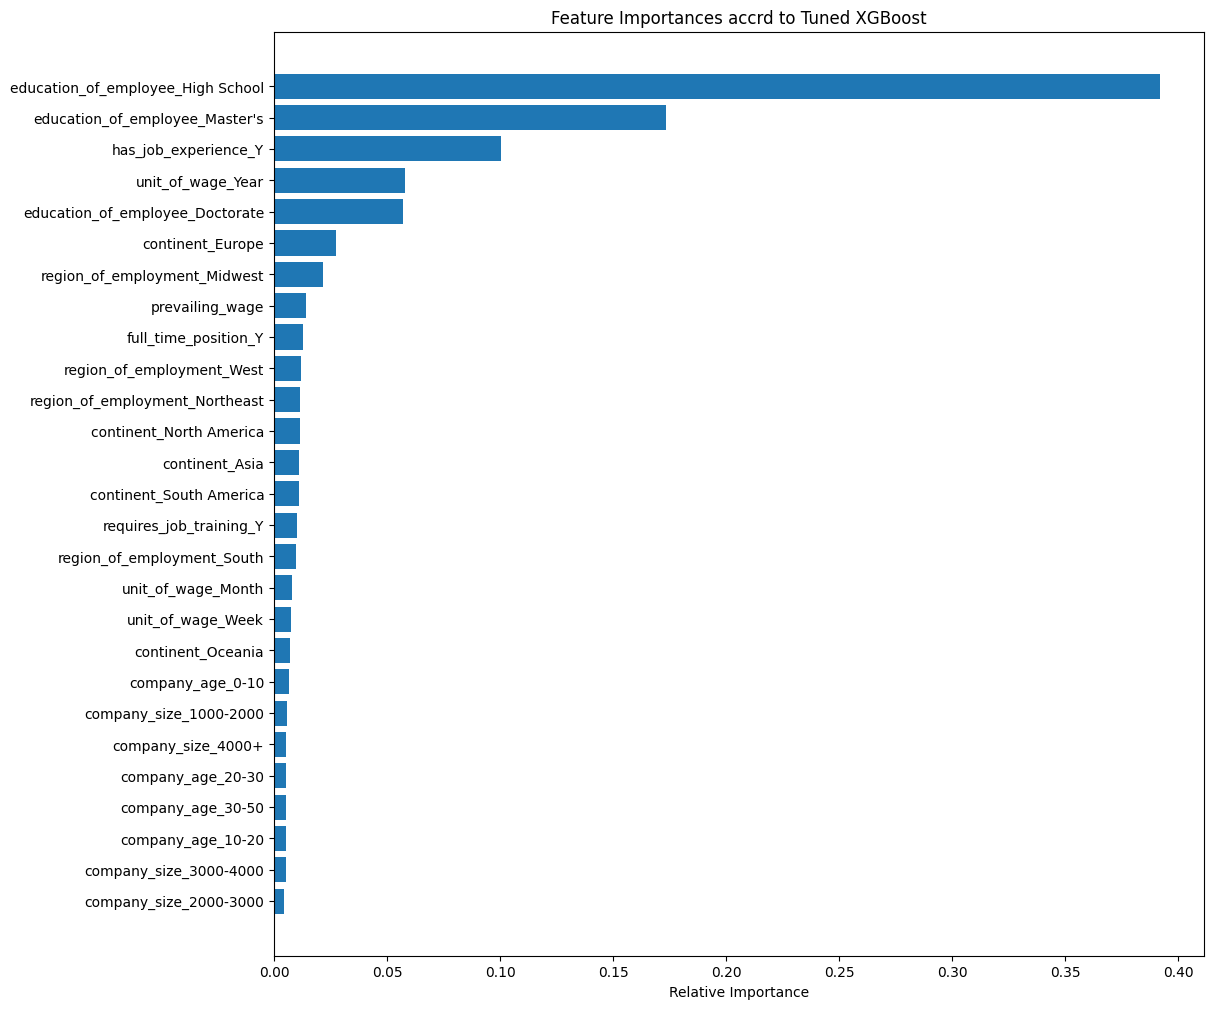

In [143]:
importances = xgb_tuned.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(12,12))
plt.title('Feature Importances accrd to Tuned XGBoost')
plt.barh(range(len(indices)), importances[indices], align='center')
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

## Actionable Insights and Recommendations

_Insights_

After analysis, it should be brought to the attention of the Office of Foreign Labor Certification (OFLC), the three most fundamental components to pre-screening an applicant:

1. Level of Education
There is a high chance that an applicant will be denied if applying to roles requiring a high school diploma. On the other hand, roles requiring a higher level of education like a Masters or Doctorate, there is a high chance that an applicant will be approved.

2. Prior Employment Experience
It it more likely for an applicant to face rejection without previous job experience.

3. Prevailing Wage
Observing the trends, it seems the higher the wage of the position, the higher the chance the applicant will be approved. 

_Recommendations_

To optimize the resources towards screening a batch of applications with a higher likelihood of approval, the OFLC can:

- Arrange applications based on the level of education, prioritizing the review of higher education levels initially.
- Organize applications according to previous job experience, giving priority to those with relevant experience.
- Review applications for salaried positions starting from the highest prevailing wage to the lowest.

- The top performing model was the Tuned XGBoost Classifier, after creating all models, then tuning them, scored the highest F1.
- The cheapest model to train was the Decision Tree as it is a very simple model, so it can be applicable in tigh times.